<a href="https://colab.research.google.com/github/Dare-Badejo-001/Optimization-Problems/blob/main/Energy_dispatch_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null

solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

## Problem description
- Power plants operate continuously to meet the country's energy demand.
- Electricity is produced from various sources, including fossil fuels and renewable energy.
- The *Optimal Power Flow (OPF)* model is used to determine the best operating levels for power plants every 15 minutes.
- OPF is an optimization problem with the objective to minimize total energy dispatching costs.
- The model ensures that energy generation meets total energy demand.
- It also considers operational and physical constraints


## Background: Power Networks and Power Flow Physics

- Transmission Network Modeling
## Background: Power Networks and Power Flow Physics

- **Transmission Network Modeling**:
  - The nation-wide power network is modeled as a directed graph $G=(V, E)$:
    - **Nodes $V$**: Cities, industrial districts, power plants.
    - **Edges $E$**: Physical transmission lines.

- **Power Injection and Demand**:
  - Each node $i \in V$ has:
    - **Power injection** $p_i$.
    - **Demand** $d_i$.
  - **Generator Nodes** $i \in \mathcal{G}$:
    - Nodes where $p_i \geq 0 $ and $ d_i = 0 $.
    - Each generator $ i $ has minimum $ p_i^{\min} $ and maximum $p_i^{\max} $ production capacity.
  - **Load Nodes** $\mathcal{D} \subseteq V $:
    - Nodes where $p_i = 0 $ and $d_i \geq 0 $.
    - Load nodes correspond to electricity consumption areas like cities and industrial districts.


- **Supply and Demand Matching**:
  - Supply and demand are matched if  : $\sum_{i \in V} p_i - d_i = 0 $.  
  - Electricity supply must meet demand at all times,
  adjusted every 15 minutes via OPF.

- **Power Flow on Edges**:
  - Each edge $(i, j) \in E$ carries a *power flow* $f_{ij} \in R$.
  - **Capacity** $f_{ij}^{\max} \geq 0$ is the maximum power flow the edge can carry.
  - Directed graph modeling allows edges to carry 'negative' flow $f_{ij} < 0$, meaning flow goes from $j$ to $i$ .
  - Flow capacity constraints: $|f_{ij}| = |f_{ji}| \leq f_{ij}^{\max}$.

- **Power Flow Physics**:
  - Power flows are determined by electrical laws, not directly controlled.
  - **Phase Angle  $\theta_{i}** of node $i$.
  - **Line Susceptance \$b_{ij}$** for each edge $(i, j)$.

- **DC Power Flow Equations**:
  - Assuming matched supply and demand $\sum_{i=1}^{n} p_i - d_i = 0$,:
  - **(1) Flow Conservation and **
  - ** (2) Flow Dependency on Susceptance and Angle Differences**::
 $$\begin{align}
p_i - d_i &= \sum_{j: (i, j) \in E} f_{ij} - \sum_{j: (j, i) \in E} f_{ji}, & \forall \, i \in V,\\
  f_{ij} &=  b_{ij}(\theta_i - \theta_j), & \forall \, (i, j) \in E.
\end{align}$$

  - **Unique Solution**:
    - Given matched power injections $\mathbf{p}$ and demand $\mathbf{d}$ , the power flows $\mathbf{f}$  and phase angles $\mathbf{theta}$  are obtained by solving these linear equations.
    - The system has exactly  $|V|$ and $|E|$  equations for $\theta_i$ and $ f_{ij}$ variables, ensuring a solution.


## Optimal Power Flow problem

We assumed above that the power injections $\mathbf{p}$ were given. However, in practice, the power injections need to be determined for each generator in the power network, where some types of generators may be cheaper than others. Moreover, we need to take into account operational constraints, such as the maximum flow and generator limits.

On the short-time scale, the power injections are calculated for each generator by solving the so-called *Optimal Power Flow (OPF)* problem. The goal of the OPF problem is to determine a solution $(\mathbf{p}, \mathbf{f}, \mathbf{\theta})$ with minimal costs such that:
- Supply meets demand
- Line capacity constraints are met
- Generator capacity constraints are met

Let $c_i > 0$ be the cost associated with the production of a unit energy by generator $i$. Then, the OPF problem can be formulated as

$$
\begin{align*}
\min        \, & \sum_{i \in V} c_i p_i \\
\text{s.t.} \, & \sum_{j: (i, j) \in E} f_{ij} - \sum_{j: (j, i) \in E} f_{ji} = p_i - d_i & \forall \, i \in V\\
            & f_{ij} =  b_{ij}(\theta_i - \theta_j)                                    & \forall \, (i, j) \in E \\
            & |f_{ij}| \leq  f_{ij}^{\max}                                              & \forall \,(i, j) \in E\\
            & p_{i}^{\min } \leq p_{i} \leq p_{i}^{\max }                               & \forall \,i \in V \\
            & p_i \geq 0                                                                & \forall \,i \in V \\
            & \theta_i \in \mathbb{R}                                                   & \forall \,i \in V \\
            & f_{ij} \in \mathbb{R}                                                     & \forall \,(i, j) \in E.
\end{align*}
$$

For simplicity, you may assume that all load nodes do not produce energy, i.e., $p_i = p_i^{\min} = p_i^{\max} = 0$ for all $i \in \mathcal{D}$. You may therefore model $p_i$ as decision variables for all nodes (both generator and load nodes). Similarly, you may assume that all generator nodes have no demand, i.e., $d_i = 0$ for all $i \in \mathcal{G}$.

To summarize, the decision variables in the OPF problem are:
- $p_i$ power injections
- $\theta_i$ phase angles
- $f_{ij}$ power flows

All the other quantities are instance-dependent parameters. Each instance captures the network in a different moment in time, thus with different energy demand at each node and different realizations for the power produced by renewable energy sources.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from ast import literal_eval as make_tuple

# Download the data
base_url = "https://raw.githubusercontent.com/mobook/MO-book/main/notebooks/04/data/"
nodes_df = pd.read_csv(base_url + "nodes.csv", index_col=0)
edges_df = pd.read_csv(base_url + "edges.csv", index_col=0)

# Read all instances
nodes = nodes_df.groupby("instance").apply(
    lambda data: data.set_index("node_id").T.to_dict()
)
edges = edges_df.set_index(edges_df["edge_id"].apply(make_tuple)).T.to_dict()
I = [{"nodes": n, "edges": edges} for n in nodes]

# Initialize a network for demonstration purposes
network = I[0]
example_nodes = nodes_df[nodes_df.instance == 0]
example_edges = nodes_df[nodes_df.instance == 0]

In [6]:
def visualize_network(network, edge_flows=None, ax=None):
    """Visualize a network instance, highlighting the generators in orange and the load buses in green."""
    plt.figure(figsize=(12, 10))
    g = nx.DiGraph(network["edges"].keys())
    pos = nx.layout.kamada_kawai_layout(g, weight=None)

    color_mapping = {
        "solar": "#ffcb36",
        "wind": "white",
        "hydro": "#a5efff",
        "coal": "#686868",
        "gas": "#00ab4e",
        np.nan: "#b6b6b6",
    }

    vertex2color = {
        i: color_mapping[data["energy_type"]] for i, data in network["nodes"].items()
    }
    v2c_list = [vertex2color[i] for i in g.nodes]  # Order based on networkx

    nodes = nx.draw_networkx_nodes(
        g,
        pos,
        node_size=250,
        node_color=v2c_list,
        linewidths=2,
    )
    edges = nx.draw_networkx_edges(
        g,
        pos,
        width=2,
        edge_color="#595959",
    )

    # Gives node colors
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#595959")
    ax.set_axis_off()

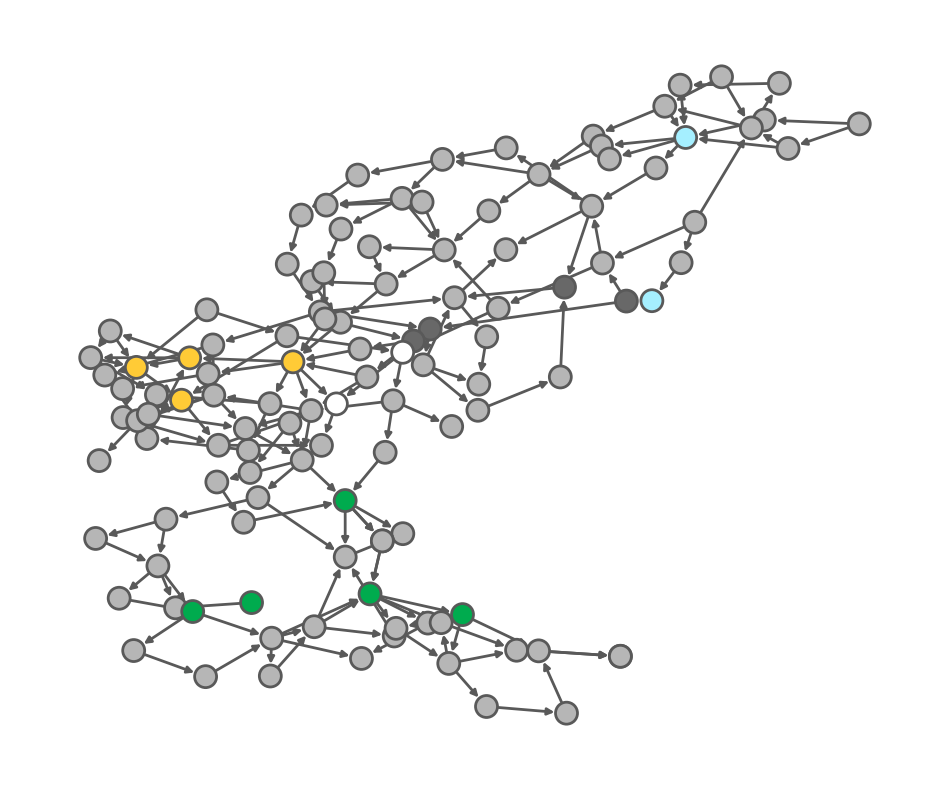

In [7]:
visualize_network(network)

In [8]:
example_nodes[example_nodes.is_generator]

,node_id,d,p_min,p_max,c_var,is_generator,energy_type,instance
9,9,0.0,0.000000,400.000000,0.000000,True,hydro,0
11,11,0.0,0.000000,200.000000,0.000000,True,hydro,0
24,24,0.0,0.000000,397.800000,28.948321,True,coal,0
25,25,0.0,0.000000,873.000000,22.220980,True,coal,0
30,30,0.0,0.000000,612.000000,25.993982,True,coal,0
45,45,0.0,0.000000,720.000000,24.202306,True,coal,0
48,48,0.0,0.000000,0.000000,0.000000,True,solar,0
53,53,0.0,0.000000,0.000000,0.000000,True,solar,0
58,58,0.0,0.000000,0.000000,0.000000,True,solar,0
60,60,0.0,0.000000,0.000000,0.000000,True,solar,0


In [9]:
example_nodes[~example_nodes.is_generator]

,node_id,d,p_min,p_max,c_var,is_generator,energy_type,instance
0,0,28.186145,0.0,0.0,0.0,False,NaN,0
1,1,10.921628,0.0,0.0,0.0,False,NaN,0
2,2,22.884795,0.0,0.0,0.0,False,NaN,0
3,3,21.961682,0.0,0.0,0.0,False,NaN,0
4,4,0.000000,0.0,0.0,0.0,False,NaN,0
...,...,...,...,...,...,...,...,...
113,113,4.396000,0.0,0.0,0.0,False,NaN,0
114,114,11.864042,0.0,0.0,0.0,False,NaN,0
115,115,108.311328,0.0,0.0,0.0,False,NaN,0
116,116,10.703998,0.0,0.0,0.0,False,NaN,0


In [10]:
edges_df

,edge_id,b,f_max
0,"(0, 1)",10.0100,271
1,"(0, 2)",23.5849,271
2,"(3, 4)",125.3133,316
3,"(2, 4)",9.2593,315
4,"(4, 5)",18.5185,316
...,...,...,...
174,"(64, 65)",28.9059,1427
175,"(67, 68)",28.9059,1427
176,"(80, 79)",28.9059,1427
177,"(86, 85)",4.8216,253


In [11]:
network["nodes"][1]["d"]

10.921627803299574

In [12]:
[i for i, data in network["nodes"].items() if data["is_generator"]]

[9, 11, 24, 25, 30, 45, 48, 53, 58, 60, 64, 65, 79, 86, 88, 99, 102, 110]

In [13]:
def OPF1(network):
    """
    Input:
    - network: a dictionary containing:
      - a dictionary of nodes with a dictionary of attributes
      - a dictionary of edges with a dictionary of attributes

    Output:
    - power_generation: a dictionary containing the power generation for each node
    - power_flows: a dictionary containing the power flow for each edge
    """

    # Define a model
    model = pyo.ConcreteModel("Q1")

    # Declare decision variables
    model.p = pyo.Var(network["nodes"], domain=pyo.NonNegativeReals)
    model.theta = pyo.Var(network["nodes"], domain=pyo.Reals)
    model.fabs = pyo.Var(network["edges"], domain=pyo.NonNegativeReals)
    model.fp = pyo.Var(network["edges"], domain=pyo.NonNegativeReals)
    model.fm = pyo.Var(network["edges"], domain=pyo.NonNegativeReals)

    # Declare objective value
    @model.Objective(sense=pyo.maximize)
    def objective(model):
        return sum(
            data["c_var"] * model.p[i]
            for i, data in network["nodes"].items()
            if data["is_generator"]
        )

    @model.Expression(network["nodes"])
    def outgoing_flow(m, i):
        return sum(
            m.fp[i, j] - m.fm[i, j]
            for j in network["nodes"]
            if (i, j) in network["edges"]
        )

    @model.Expression(network["nodes"])
    def incoming_flow(m, i):
        return sum(
            m.fp[j, i] - m.fm[j, i]
            for j in network["nodes"]
            if (j, i) in network["edges"]
        )

    @model.Constraint(network["nodes"])
    def flow_conservation(m, i):
        return (
            m.outgoing_flow[i] - m.incoming_flow[i] == m.p[i] - network["nodes"][i]["d"]
        )

    @model.Constraint(network["edges"])
    def susceptance(m, i, j):
        return m.fp[i, j] - m.fm[i, j] == network["edges"][(i, j)]["b"] * (
            m.theta[i] - m.theta[j]
        )

    @model.Constraint(network["edges"])
    def abs_flow(m, *e):
        return m.fabs[e] == m.fp[e] + m.fm[e]

    @model.Constraint(network["edges"])
    def flows_upper_bound(m, *e):
        return m.fabs[e] <= network["edges"][e]["f_max"]

    @model.Constraint(network["nodes"])
    def generation_upper_bound(m, i):
        return m.p[i] <= network["nodes"][i]["p_max"]

    @model.Constraint(network["nodes"])
    def generation_lower_bound(m, i):
        return network["nodes"][i]["p_min"] <= m.p[i]

    # Solve
    result = SOLVER.solve(model)

    return model.objective()

In [14]:
sol1 = [OPF1(instance) for instance in I]
print(f"The average objective value over all instances is: {np.mean(sol1):.2f}")

The average objective value over all instances is: 102898.76


In [15]:
def OPF2(network):
    """
    Input:
    - network: a dictionary containing:
      - a dictionary of nodes with a dictionary of attributes
      - a dictionary of edges with a dictionary of attributes

    Output:
    - power_generation: a dictionary containing the power generation for each node
    - power_flows: a dictionary containing the power flow for each edge
    """

    # Define a model
    model = pyo.ConcreteModel("Q2")

    # Declare decision variables
    model.p = pyo.Var(network["nodes"], domain=pyo.NonNegativeReals)
    model.theta = pyo.Var(network["nodes"], domain=pyo.Reals)
    model.fabs = pyo.Var(network["edges"], domain=pyo.NonNegativeReals)
    model.fp = pyo.Var(network["edges"], domain=pyo.NonNegativeReals)
    model.fm = pyo.Var(network["edges"], domain=pyo.NonNegativeReals)
    model.x = pyo.Var(network["nodes"], domain=pyo.Binary)

    # Declare objective value
    @model.Objective(sense=pyo.minimize)
    def objective(model):
        return sum(
            data["c_var"] * model.p[i]
            for i, data in network["nodes"].items()
            if data["is_generator"]
        )

    # Declare constraints
    @model.Expression(network["nodes"])
    def outgoing_flow(m, i):
        return sum(
            m.fp[i, j] - m.fm[i, j]
            for j in network["nodes"]
            if (i, j) in network["edges"]
        )

    @model.Expression(network["nodes"])
    def incoming_flow(m, i):
        return sum(
            m.fp[j, i] - m.fm[j, i]
            for j in network["nodes"]
            if (j, i) in network["edges"]
        )

    @model.Constraint(network["nodes"])
    def flow_conservation(m, i):
        return (
            m.outgoing_flow[i] - m.incoming_flow[i] == m.p[i] - network["nodes"][i]["d"]
        )

    @model.Constraint(network["edges"])
    def susceptance(m, i, j):
        return m.fp[i, j] - m.fm[i, j] == network["edges"][(i, j)]["b"] * (
            m.theta[i] - m.theta[j]
        )

    @model.Constraint(network["edges"])
    def abs_flows(m, *e):
        return m.fabs[e] == m.fp[e] + m.fm[e]

    @model.Constraint(network["edges"])
    def flows_upper_bound(m, *e):
        return m.fabs[e] <= network["edges"][e]["f_max"]

    @model.Constraint(network["nodes"])
    def generation_upperound(m, i):
        return m.p[i] <= network["nodes"][i]["p_max"] * m.x[i]

    @model.Constraint(network["nodes"])
    def generation_lower_bound(m, i):
        return network["nodes"][i]["p_min"] * m.x[i] <= m.p[i]

    @model.Constraint()
    def max_gas_plants(model):
        return (
            sum(
                model.x[i]
                for i, data in network["nodes"].items()
                if data["energy_type"] == "gas"
            )
            <= 2
        )

    @model.Constraint()
    def max_coal_plants(model):
        return (
            sum(
                model.x[i]
                for i, data in network["nodes"].items()
                if data["energy_type"] == "coal"
            )
            <= 1
        )

    # Solve
    result = SOLVER.solve(model)

    return model.objective()

In [19]:
sol2 = [OPF2(instance) for instance in I]
print(f"The average objective value over all instances is: {np.mean(sol2):.2f}")

The average objective value over all instances is: 53120.81


In [20]:

def OPF3(network):
    """
    Input:
    - network: a dictionary containing:
      - a dictionary of nodes with a dictionary of attributes
      - a dictionary of edges with a dictionary of attributes

    Output:
    - power_generation: a dictionary containing the power generation for each node
    - power_flows: a dictionary containing the power flow for each edge
    """

    # Define a model
    model = pyo.ConcreteModel("Q3")

    # Declare decision variables
    model.p = pyo.Var(network["nodes"], domain=pyo.NonNegativeReals)
    model.theta = pyo.Var(network["nodes"], domain=pyo.Reals)
    model.fabs = pyo.Var(network["edges"], domain=pyo.NonNegativeReals)
    model.fp = pyo.Var(network["edges"], domain=pyo.NonNegativeReals)
    model.fm = pyo.Var(network["edges"], domain=pyo.NonNegativeReals)
    model.x = pyo.Var(network["nodes"], domain=pyo.Binary)
    model.y = pyo.Var(domain=pyo.Binary)

    # Big-Ms
    max_total_renewable_production = sum(
        data["p_max"]
        for i, data in network["nodes"].items()
        if data["energy_type"] in ["solar", "wind", "hydro"]
    )
    M = [4, 3, max_total_renewable_production - 1000]

    # Declare objective value
    @model.Objective(sense=pyo.minimize)
    def objective(m):
        return sum(
            data["c_var"] * m.p[i]
            for i, data in network["nodes"].items()
            if data["is_generator"]
        )

    # Declare constraints
    @model.Expression(network["nodes"])
    def outgoing_flow(m, i):
        return sum(
            m.fp[i, j] - m.fm[i, j]
            for j in network["nodes"]
            if (i, j) in network["edges"]
        )

    @model.Expression(network["nodes"])
    def incoming_flow(m, i):
        return sum(
            m.fp[j, i] - m.fm[j, i]
            for j in network["nodes"]
            if (j, i) in network["edges"]
        )

    @model.Constraint(network["nodes"])
    def flow_conservation(m, i):
        return (
            m.outgoing_flow[i] - m.incoming_flow[i] == m.p[i] - network["nodes"][i]["d"]
        )

    @model.Constraint(network["edges"])
    def susceptance(m, i, j):
        return m.fp[i, j] - m.fm[i, j] == network["edges"][(i, j)]["b"] * (
            m.theta[i] - m.theta[j]
        )

    @model.Constraint(network["edges"])
    def abs_flows(m, *e):
        return m.fabs[e] == m.fp[e] + m.fm[e]

    @model.Constraint(network["edges"])
    def flows_upper_bound(m, *e):
        return m.fabs[e] <= network["edges"][e]["f_max"]

    @model.Constraint(network["nodes"])
    def generation_upper_bound(m, i):
        return m.p[i] <= network["nodes"][i]["p_max"] * m.x[i]

    @model.Constraint(network["nodes"])
    def generation_lower_bound(m, i):
        return network["nodes"][i]["p_min"] * m.x[i] <= m.p[i]

    @model.Constraint()
    def max_gas_plants(m):
        return (
            sum(
                m.x[i]
                for i, data in network["nodes"].items()
                if data["energy_type"] == "gas"
            )
            <= 2 + (1 - m.y) * M[0]
        )

    @model.Constraint()
    def max_coal_plants(m):
        return (
            sum(
                m.x[i]
                for i, data in network["nodes"].items()
                if data["energy_type"] == "coal"
            )
            <= 1 + (1 - m.y) * M[1]
        )

    @model.Constraint()
    def renewable_energy_production(m):
        return (
            sum(
                m.p[i]
                for i, data in network["nodes"].items()
                if data["energy_type"] in ["solar", "wind", "hydro"]
            )
            <= 1000 + m.y * M[2]
        )

    # Solve
    result = SOLVER.solve(model)

    return model.objective()

In [21]:
sol3 = [OPF3(instance) for instance in I]
print(f"The average objective value over all instances is: {np.mean(sol3):.2f}")

The average objective value over all instances is: 41608.73


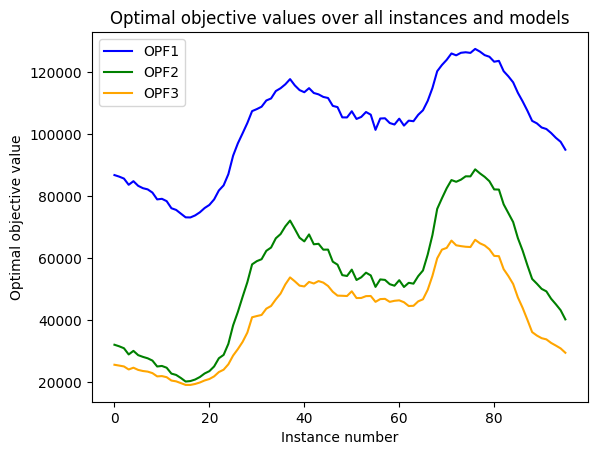

In [22]:
objs = [sol1, sol2, sol3]
plt.plot(objs[0], color="blue", label="OPF1")
plt.plot(objs[1], color="green", label="OPF2")
plt.plot(objs[2], color="orange", label="OPF3")
plt.title("Optimal objective values over all instances and models")
plt.xlabel("Instance number")
plt.ylabel("Optimal objective value")
plt.legend()
plt.show()